## Mackey-Glass equation - 1D example

The Mackey-Glass equation considers the population of mature blood cells, $x(t)$, and models the process of the production of these cells. It has the following delay differential equation (DDE) system:

```math
\begin{align}
  \dot{x}&= \frac{\beta x(t-\tau)}{1+[x(t-\tau)]^n}- \gamma x(t)\\
\end{align}
```
where $\beta$ expresses the dependence of blood cell production on the number of mature cells already in the system; where $\gamma$ is the death rate of mature cells and where $\tau$ is the delay between the production of blood cells in the bone marrow and the time taken to release these into the system (blood stream) (Manjunath, Raina 2014).

The following packages and functions are needed:

In [73]:
using CairoMakie
using LinearAlgebra

include("../DDETools/DDETools.jl") 
using .DDETools
include("mackeyglassfunc.jl") #system of Mackey-Glass equation
include("mackeytau.jl") #Delay formula for Mackey-Glass equation

mackeytau (generic function with 1 method)

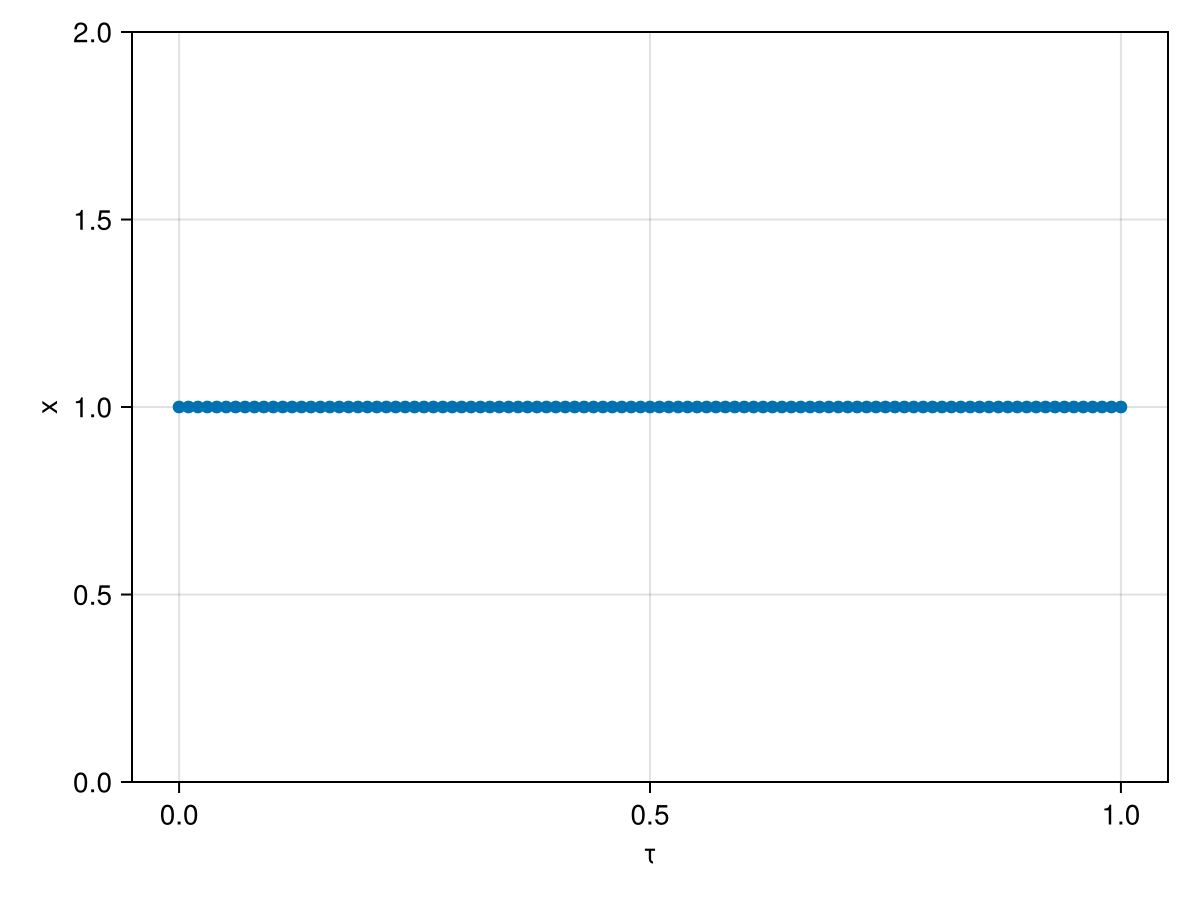

In [ ]:
#Initial states for following parameters (same as those given in Mackey-Glass DDE-Biftool example)
gamma=1.0
beta=2 
n=10 
tau=0 #delay
x0=((beta-gamma)/(gamma))^(1/n) #obtained from solving f(x*,...,x*)=0
nd=1 #one delay

y01,feq= DDETools.create_ststfunc(mackeyglassfunc, x0, [beta,gamma,n,tau],nd, par_indx=4) #finds initial equilibrium point and creates a function to find the equilibria branch
ylist1,ytan1= DDETools.track_curve(feq,y01,[0.0,1],stepsize=0.01,nmax=100) #tracks equilibria to find the equilibria branch

#Below plots the equilibiria branch
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="τ",ylabel="x")
scatter!(ax1,[u[2] for u in ylist1],[u[1] for u in ylist1])
lines!(ax1,[u[2] for u in ylist1],[u[1] for u in ylist1])
fig1

In [75]:
#check that f(x*,...x*,pars)=0
feq(y01)

1-element Vector{Float64}:
 0.0

# Stability - approximating using a large matrix

Finding the stability of equilibiria of DDEs is more complex than finding the stability of equilibria of ODEs due to the infinite dimensional past of DDEs. For this part of the example, the stability was found by using a large matrix that can be used to create a finite-dimensional system that can approximate the stability of the equilibria. The function ``` stab_func_matrix ``` utilises this method and has a first output of `1` is the equilibrium point if stable and has `0` if it is unstable. Below we find the stability of one equilibrium point, where $\tau$ is taken to be 0.4:

In [76]:
#stability of an equilibrium point
DDETools.stab_func_matrix(mackeyglassfunc,mackeytau, [x0], [0.4],[gamma,beta,n,tau], [4], nd, doprint=1)

(1, ComplexF64[-486.6443159194877 + 0.0im, -486.183026118484 - 14.786984412212126im, -486.183026118484 + 14.786984412212126im, -484.80093909657637 - 29.516609950370288im, -484.80093909657637 + 29.516609950370288im, -482.5033950836206 - 44.13173934350338im, -482.5033950836206 + 44.13173934350338im, -479.2992714442893 - 58.57567766687368im, -479.2992714442893 + 58.57567766687368im, -475.2009482429123 - 72.79239136877224im  …  -16.96036821249696 - 63.1703274404643im, -16.96036821249696 + 63.1703274404643im, -12.830555667381233 - 48.573045787450724im, -12.830555667381233 + 48.573045787450724im, -9.371065016542675 - 33.71835565346033im, -9.371065016542675 + 33.71835565346033im, -6.2905194080540525 - 18.625248124910794im, -6.2905194080540525 + 18.625248124910794im, -1.7833392917706055 - 4.032566044790773im, -1.7833392917706055 + 4.032566044790773im], ComplexF64[0.0013307886027846038 + 0.0im 0.0013307594886547967 - 4.064149041508349e-5im … -0.0036048896431034867 - 0.06709548624977114im -0.003

Note that the stability indicator is `1` so the above equilbrium point is stable. We'll now find the stability for all the points on the equilibria branch, which are given in the vector ```stab```:

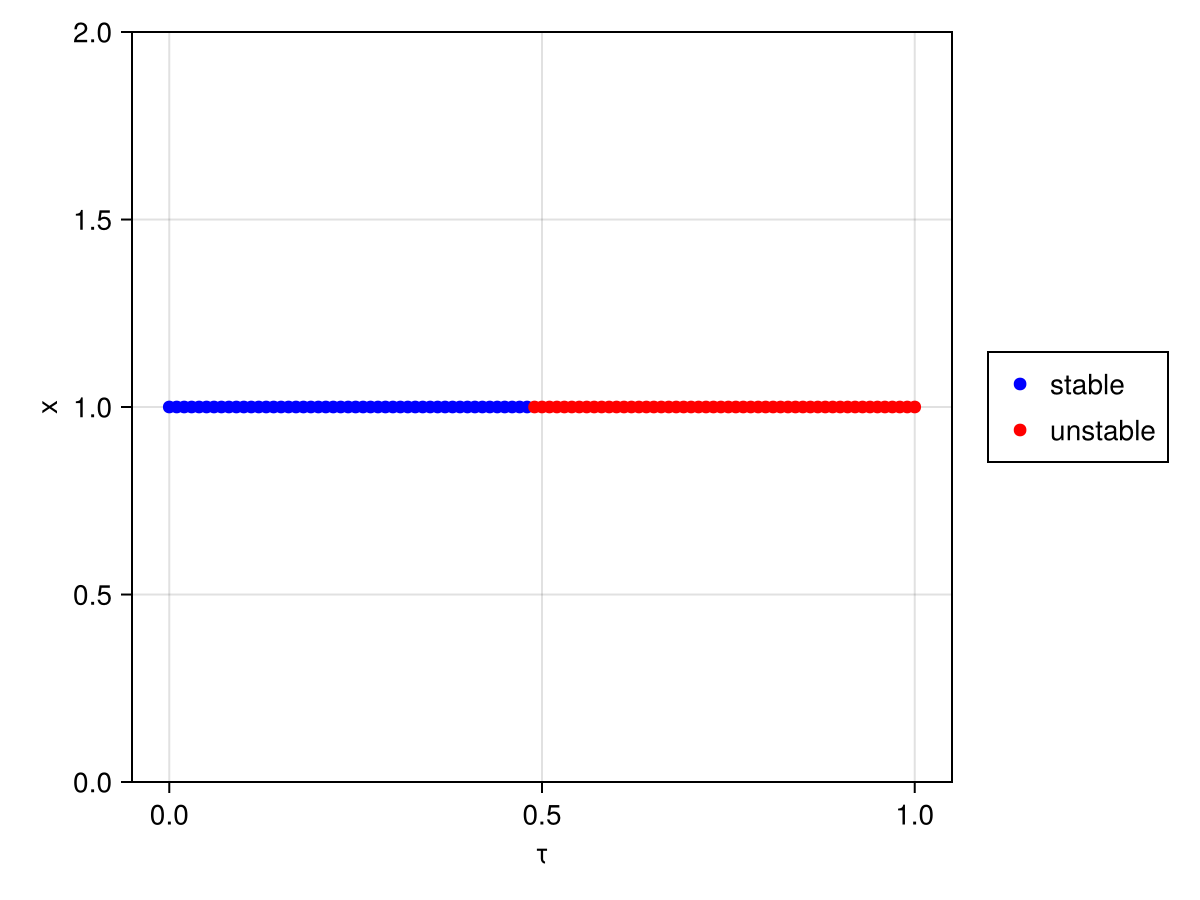

In [77]:
xmat1=hcat([u[1] for u in ylist1]) #finds values of equilibiria points (x)
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)] #turns values of equilibria points into vector of vectors

plist1=[u[2] for u in ylist1] #Delay value, τ, for each equilibrium point

m=100 #number of discretised steps
nx=1 #number of states 
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq) #creates blank array for stability indicator
stab[1]=1.0 #Note this is an educated guess, the function stab_func_matrix currently doesn't work for delay=0

for i in 2:neq
    stab[i]=DDETools.stab_func_matrix(mackeyglassfunc,mackeytau,xlist1[i],[plist1[i]],[beta, gamma,n,tau],[4],nd,doprint=0,m=m)[1] #returns stability of each equilibirum point (1=stable,0=unstable)
end

stable=(stab.==1.0) #highlights stable indices
unstable=(stab.==0.0) #highlights unstable indices

#Below creates plot to show the stability of the equilibiria
fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="τ",ylabel="x")
scatter!(ax2,plist1[stable],[u[1] for u in xlist1[stable]], color="blue", label="stable")
scatter!(ax2,plist1[unstable],[u[1] for u in xlist1[unstable]], color="red", label="unstable")
Legend(fig2[1,2], ax2, merge=true)
fig2


# Stability using Breda et al (2009) method

The function ```stab_func_DDE``` uses the method described in (Breda et al 2009) to find the stability and the eigenvalues (and if asked the eigenvectors) of an equilibrium point. For more information on this function, see the "Stability_finding_for_DDEs.ipynb" notebook located in the "DDE_stability_breda_et_al" folder. To use ```stab_func_DDE``` for analysis of Mackey-Glass equilibria, the partial derivative matrices $A_0, A_1$ need to be found for $x=1$ (equilibrium point). These can be found either manually or by using ```f_deriv```. In this example we'll use ```f_deriv``` so we can loop over all the equilibrium points.

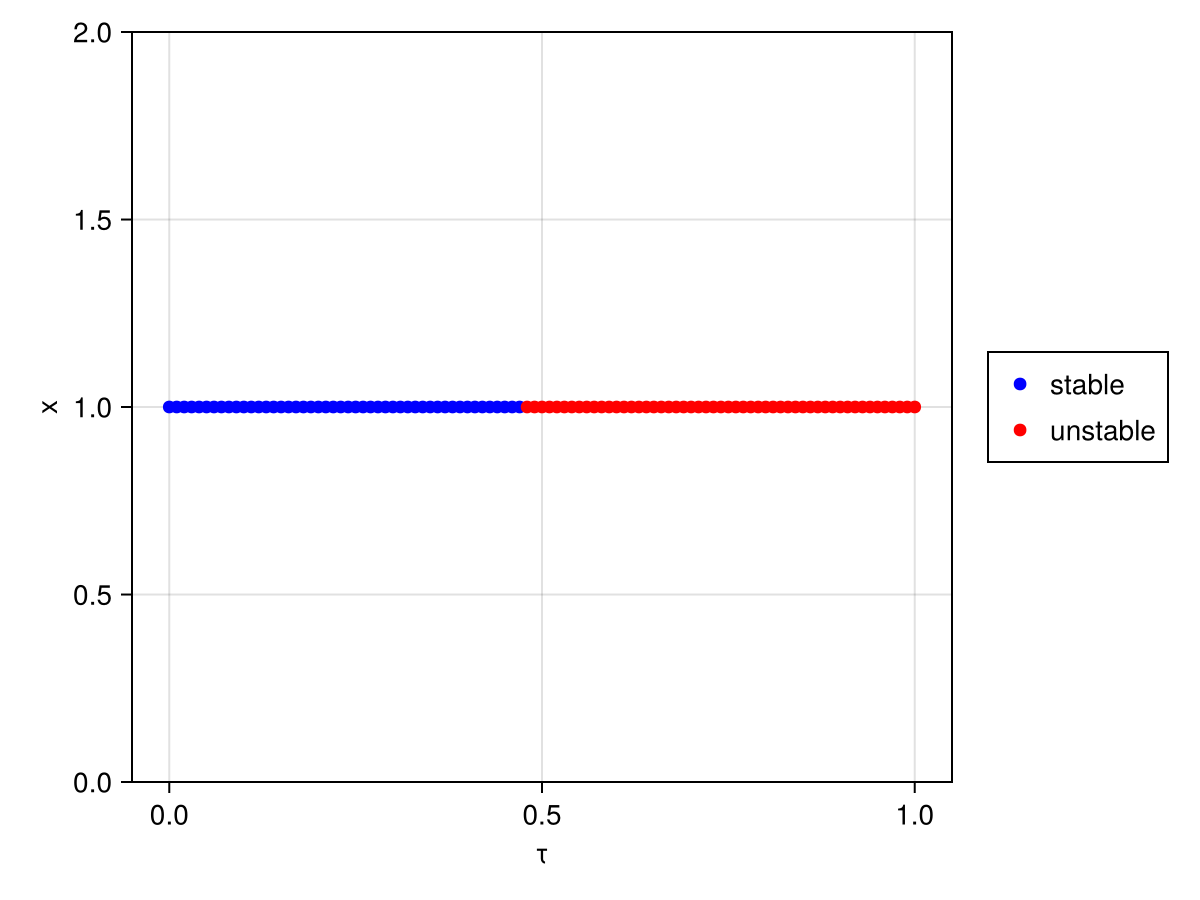

In [78]:
N=110 #so there are 111 interpolation points
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab_DDE=fill(NaN,neq)
stab_DDE[1]=1.0 #Note again this is an educated guess, the function stab_func_DDE currently doesn't work for delay=0

for i in 2:neq
    A0=DDETools.f_deriv(mackeyglassfunc, xlist1[i],[beta, gamma,n,plist1[i]],nd,nx=1) #finds partial derivative matrix with respect to x(t)
    A1=DDETools.f_deriv(mackeyglassfunc, xlist1[i],[beta, gamma,n,plist1[i]],nd,nx=2) #finds partial derivative matrix with respect to x(t-τ)
    stab_DDE[i],=DDETools.stab_func_DDE([vec(A0),vec(A1)],[plist1[i]],N) #gives stability of each equilibrium point
end

stableDDE=(stab_DDE.==1.0) #highlights indices of stable points (indicated by a 1 in stable vector)
unstableDDE=(stab_DDE.==0.0)#highlights indices of unstable points (indicated by a 1 in unstable vector)

#Below plots the equilibria and shows their stability
fig3=Figure()
ax3=Axis(fig3[1,1],xlabel="τ",ylabel="x")
scatter!(ax3,plist1[stableDDE],[u[1] for u in xlist1[stableDDE]],label="stable",color="blue")
scatter!(ax3,plist1[unstableDDE],[u[1] for u in xlist1[unstableDDE]],label="unstable",color="red")
Legend(fig3[1,2], ax3, merge=true)
fig3

# Hopf Bifurcation

The eigenvalues of the linearised system determine the equilibrium's stability. A Hopf bifurcation occurs when the stability behaviour changes and a pair of complex conjugate eigenvalues of the linearised system crosses the imaginary axis and become purely imaginary, i.e. $\lambda=\pm \omega i$. We start finding the Hopf parameters by first finding the initial guess of the τ value for the Hopf bifurcation.

Note that while the initial guess of $\tau$ for a Hopf bifurcation can be found using both ```stab_func_matrix``` and ```stab_func_DDE```, the true Hopf bifurcation can only be found when using the stability function ```stab_func_matrix``` as ```create_hopffunc``` has been made to, currently, only work for ```stab_func_matrix```. The code for finding the initial guesses of $\tau$ for the two different stability methods is given below:

In [79]:
#Initial guess for τ for Hopf bifurcation using stab_func_matrix results
hopf_indx=findfirst(isequal(0.0), stab) #finds index of initial parameter guess
p_hopf_est=plist1[hopf_indx] #initial guess for τ for Hopf bifurcation from stab_func_matrix

0.49000000000000027

In [80]:
#Initial guess for τ for Hopf bifurcation using stab_func_DDE results
hopf_DDEindx=findfirst(isequal(0.0), stab_DDE) #finds index of initial parameter guess
p_hopf_DDEest=plist1[hopf_DDEindx] #initial guess for τ for Hopf bifurcation from stab_func_DDE

0.48000000000000026

Having found the initial guess (taking the one given by ```stab_func_matrix```) for the $\tau$ value of the Hopf bifurcation, we now find the $\omega$ value and true value of $\tau$ for the Hopf bifurcation:

In [ ]:
yh01,fhopf=DDETools.create_hopffunc(mackeyglassfunc,mackeytau,[beta,gamma,n,tau],xlist1[hopf_indx],[plist1[hopf_indx]],[4],nd) #outputs initial guess of the Hopf bifurcation (including x, ω and τ estimates) and a function that contains the method/formula to find the Hopf bifurcation
println("The initial guess for Hopf info: $yh01")
yh1,conv1,=DDETools.newton(fhopf,yh01) #putting initial guess and Hopf function into newton we get the true parameter values and information for the Hopf bifurcation
println("The true information for the Hopf bifurcation: $yh1")
println("converged?: $conv1")
tau_hopf=yh1[end]
om_hopf=yh1[end-1]
x_hopf=yh1[1]
println("The τ value for Hopf bifurcation: $tau_hopf")
println("The ω value for Hopf bifurcation: $om_hopf")

The initial guess for Hopf info: [1.0, -1.0, 0.0, 3.750387528138904, 0.49000000000000027]
The true information for the Hopf bifurcation: [1.0, -1.0, 0.0, 3.87298334183115, 0.47081962953876083]
converged?: true
The τ value for hopf bifurcation: 0.47081962953876083
The ω value for hopf bifurcation: 3.87298334183115


In [82]:
println("The estimated τ value for Hopf bifurcation using large matrix stability (stab_func_matrix) is: $p_hopf_est")
println("The estimated τ value for Hopf bifurcation using stab_func_DDE is: $p_hopf_DDEest")
println("The true τ value for hopf bifurcation when using stab_func_matrix: $tau_hopf")

The estimated τ value for Hopf bifurcation using large matrix stability (stab_func_matrix) is: 0.49000000000000027
The estimated τ value for Hopf bifurcation using stab_func_DDE is: 0.48000000000000026
The true τ value for hopf bifurcation when using stab_func_matrix: 0.47081962953876083


We see here that ```stab_func_DDE``` is more accurate than ```stab_func_matrix``` as the initial guess of the Hopf $\tau$ value obtained from ```stab_func_DDE``` ($\approx 0.48$) is closer to the true $\tau$ Hopf value ($\approx 0.47$) than the initial guess for $\tau$ when using ```stab_func_matrix``` ($\approx 0.49$).

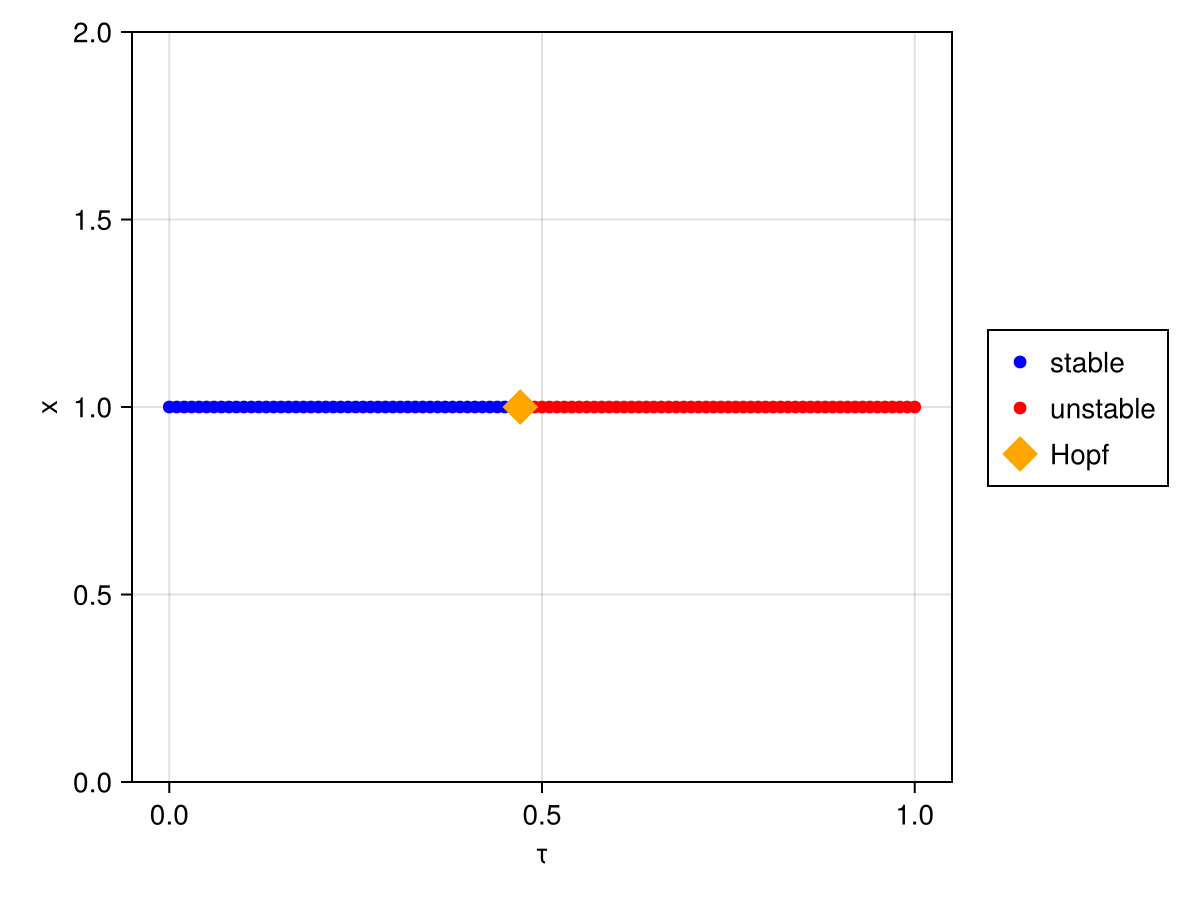

In [83]:
#Plot to show location of Hopf bifurcation
fig4=Figure()
ax4=Axis(fig4[1,1],xlabel="τ",ylabel="x")
scatter!(ax4,plist1[stable],[u[1] for u in xlist1[stable]], color="blue", label="stable")
scatter!(ax4,plist1[unstable],[u[1] for u in xlist1[unstable]], color="red",label="unstable")
scatter!(ax4,tau_hopf,x_hopf,marker=:diamond,color=:orange,markersize=:20, label="Hopf")
Legend(fig4[1,2],ax4,merge=true)
fig4

# Continuation in ($\tau$,$\beta$)-plane

We continue the Hopf points in the $\tau$ and $\beta$ parameter plane:

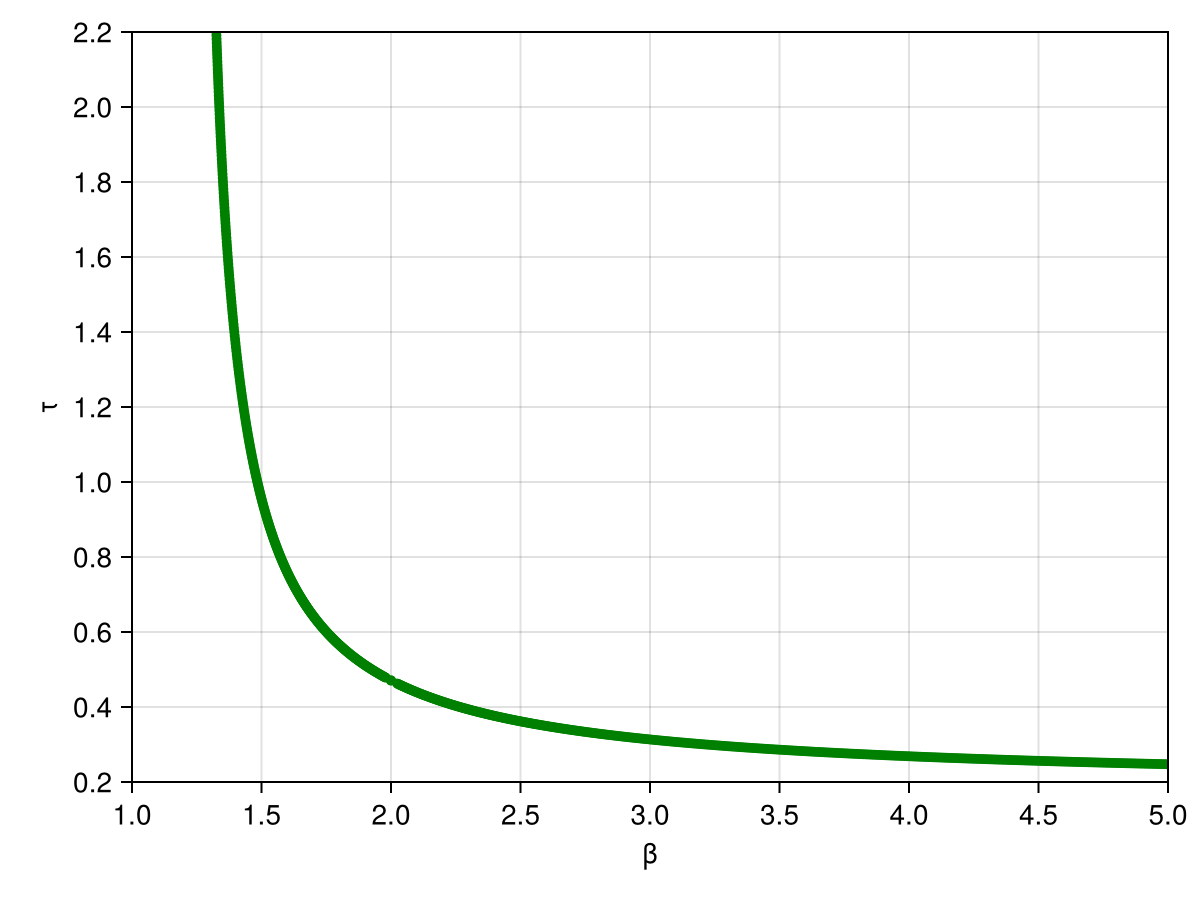

In [ ]:
yheq01,fhopfeq1=DDETools.create_hopffunc(mackeyglassfunc,mackeytau,[beta,gamma,n,tau_hopf],[x_hopf],[beta,tau_hopf],[1,4],nd) #outputs (initial) starting point of Hopf information with information on both parameters (τ and β) and the Hopf function

yheqlist1,heqtan1=DDETools.track_curve(fhopfeq1,yheq01,[-1.0,0,0,0,1,-1],nmax=500) #tracks β and τ backwards from β=2, τ≈0.47 
yheqlist2,heqtan2=DDETools.track_curve(fhopfeq1,yheq01,[-1.0,0,0,0,-1,1],nmax=500) #tracks β and τ forwards from β=2, τ≈0.47

#Plot of continuation/tracking in (τ,β) plane
fig5=Figure()
ax5=Axis(fig5[1,1],xlabel="β",ylabel="τ")
scatter!(ax5,[u[end-1] for u in yheqlist1],[u[end] for u in yheqlist1],color="green",markersize=:7)
scatter!(ax5,[u[end-1] for u in yheqlist2],[u[end] for u in yheqlist2],color="green",markersize=:7)
ylims!(ax5,[0.2,2.2])
xlims!(ax5,[1,5])
ax5.xticks=1:0.5:5
ax5.yticks=0.2:0.2:2.2
fig5

# References

1. Breda D., Maset S., Vermiglio R. (2009). 'TRACE-DDE: a Tool for Robust Analysis and Characteristic Equations for Delay Differential Equations', *Lecture Notes in Control And Information Sciences*, volume 388, pp 145-155. Available at: http://dx.doi.org/10.1007/978-3-642-02897-7_13
2. Manjunath S. and Raina G. (2014) . 'Stability and Hopf bifurcation analysis of the Mackey-Glass and Lasota equations'. *The 26th Chinese Control and Decision Conference (2014 CCDC)*, pp. 2076–2082. Available at: https://doi.org/10.1109/CCDC.2014.6852509